# Test et Évaluation des Modèles ML
## Validation des fonctionnalités Intelligence Territoriale

Ce notebook permet de tester les 3 modèles ML de l'application :
1. **Profils de communes** (Clustering K-Means)
2. **Score de tension immobilière** (Calcul composite)
3. **Prédiction d'évolution** (Régression linéaire)

---

## 1. Imports et chargement des données

In [4]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import sys
sys.path.append('..')
import ml_models as ml
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports OK")

✅ Imports OK


In [5]:
# Charger les données cartographiques (2022)
data_carto = pd.read_csv('../SORTIE/data_clean_2022.csv')

# Charger les données historiques (évolution)
datahab = pd.read_csv('../SORTIE/TAB_TYPEHAB.csv')

print(f"✅ Données chargées : {len(data_carto)} communes")
print(f"✅ Données historiques : {len(datahab)} lignes")
print(f"\nAperçu des colonnes disponibles :")
print(data_carto.columns.tolist())

✅ Données chargées : 691 communes
✅ Données historiques : 13862 lignes

Aperçu des colonnes disponibles :
['insee_com', 'REG', 'DEP', 'LIBGEO', 'LOG', 'RP', 'RSECOCC', 'LOGVAC', 'MAISON', 'APPART', 'RP_1P', 'RP_2P', 'RP_3P', 'RP_4P', 'RP_5PP', 'NBPI_RP', 'RPMAISON', 'NBPI_RPMAISON', 'RPAPPART', 'NBPI_RPAPPART', 'RP_ACHTOT', 'RP_ACH1919', 'RP_ACH1945', 'RP_ACH1970', 'RP_ACH1990', 'RP_ACH2005', 'RP_ACH2019', 'RPMAISON_ACH1919', 'RPMAISON_ACH1945', 'RPMAISON_ACH1970', 'RPMAISON_ACH1990', 'RPMAISON_ACH2005', 'RPMAISON_ACH2019', 'RPAPPART_ACH1919', 'RPAPPART_ACH1945', 'RPAPPART_ACH1970', 'RPAPPART_ACH1990', 'RPAPPART_ACH2005', 'RPAPPART_ACH2019', 'MEN', 'MEN_ANEM0002', 'MEN_ANEM0204', 'MEN_ANEM0509', 'MEN_ANEM10P', 'MEN_ANEM1019', 'MEN_ANEM2029', 'MEN_ANEM30P', 'PMEN', 'PMEN_ANEM0002', 'PMEN_ANEM0204', 'PMEN_ANEM0509', 'PMEN_ANEM10P', 'NBPI_RP_ANEM0002', 'NBPI_RP_ANEM0204', 'NBPI_RP_ANEM0509', 'NBPI_RP_ANEM10P', 'RP_PROP', 'RP_LOC', 'RP_LOCHLMV', 'RP_GRAT', 'NPER_RP', 'NPER_RP_PROP', 'NPER_

---
## 2. Test : Profils de communes (Clustering)

In [6]:
# Test avec 3 profils
n_profils = 3
data_profils, noms_profils = ml.identifier_profils_communes(data_carto, n_profils)

print(f"✅ Clustering réussi : {n_profils} profils identifiés\n")

# Afficher les profils
for profil_id, info in noms_profils.items():
    nb_communes = len(data_profils[data_profils['Profil'] == profil_id])
    print(f"\n📊 Profil {profil_id} : {info['nom']}")
    print(f"   {info['description']}")
    print(f"   → {nb_communes} communes")

# Vérifier la répartition
print("\n🔍 Répartition des communes par profil :")
print(data_profils['Profil'].value_counts().sort_index())

✅ Clustering réussi : 3 profils identifiés


📊 Profil 0 : Profil résidentiel pavillonnaire
   Propriétaires en maison (74.8% proprio)
   → 407 communes

📊 Profil 1 : Profil touristique
   Forte présence de résidences secondaires (41.2%)
   → 192 communes

📊 Profil 2 : Profil sous-tension
   Taux de vacance important (12.4%)
   → 92 communes

🔍 Répartition des communes par profil :
Profil
0    407
1    192
2     92
Name: count, dtype: int64


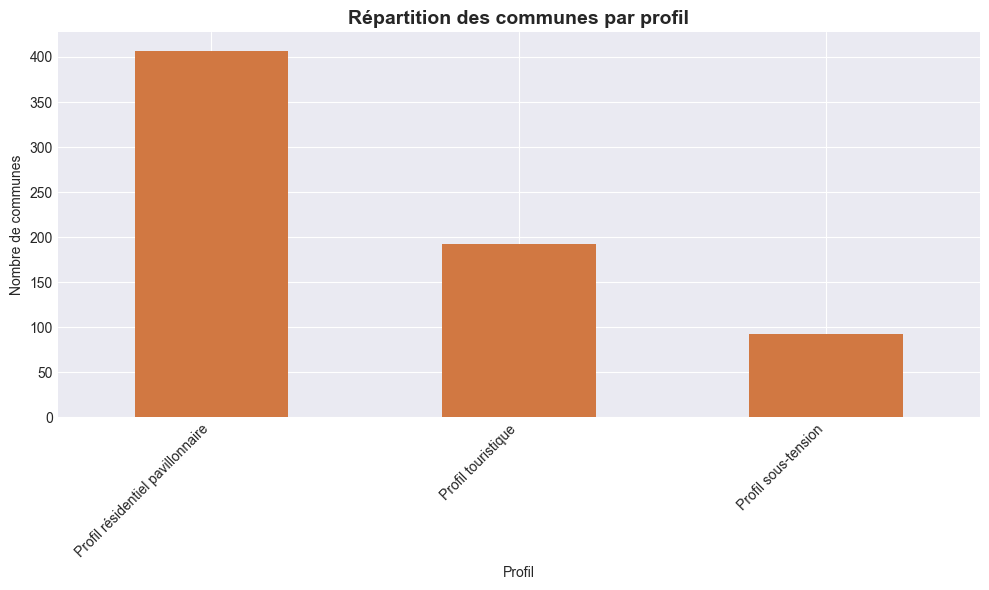

✅ Visualisation OK


In [7]:
# Visualisation de la répartition
fig, ax = plt.subplots(figsize=(10, 6))
data_profils['Profil'].value_counts().sort_index().plot(kind='bar', ax=ax, color='#d17842')
ax.set_title('Répartition des communes par profil', fontsize=14, fontweight='bold')
ax.set_xlabel('Profil')
ax.set_ylabel('Nombre de communes')
ax.set_xticklabels([noms_profils[i]['nom'] for i in sorted(noms_profils.keys())], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✅ Visualisation OK")

In [8]:
# Test : Rechercher une commune spécifique
commune_test = "Montpellier"

if commune_test in data_profils['LIBGEO'].values:
    profil = data_profils[data_profils['LIBGEO'] == commune_test]['Profil'].iloc[0]
    nom_profil = noms_profils[profil]['nom']
    print(f"\n🔎 {commune_test} appartient au profil : {nom_profil}")
    
    # Communes similaires
    communes_similaires = data_profils[data_profils['Profil'] == profil]['LIBGEO'].head(10).tolist()
    print(f"\n   Communes similaires : {', '.join(communes_similaires)}")
else:
    print(f"❌ {commune_test} introuvable dans les données")


🔎 Montpellier appartient au profil : Profil sous-tension

   Communes similaires : Aigues-Mortes, Alès, Anduze, Les Angles, Aramon, Avèze, Bagnols-sur-Cèze, Barjac, Beaucaire, Bessèges


---
## 3. Test : Score de tension immobilière

In [9]:
# Calculer les scores de tension
data_tension = ml.calculer_tension_immobiliere(data_carto)

print(f"✅ Scores de tension calculés pour {len(data_tension)} communes\n")

# Statistiques globales
print("📊 Statistiques des scores de tension :")
print(data_tension['Score_Tension'].describe())

# Répartition par niveau
print("\n🔍 Répartition par niveau de tension :")
print(data_tension['Niveau'].value_counts())

2025-11-19 17:57:59.303 No runtime found, using MemoryCacheStorageManager
2025-11-19 17:57:59.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:57:59.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:57:59.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:57:59.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:57:59.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:57:59.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:57:59.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


✅ Scores de tension calculés pour 691 communes

📊 Statistiques des scores de tension :
count    691.000000
mean      49.154559
std       15.214504
min        4.200000
25%       39.350000
50%       48.000000
75%       57.100000
max       88.800000
Name: Score_Tension, dtype: float64

🔍 Répartition par niveau de tension :
Niveau
🟡 Modérée        502
🟠 Élevée          96
🟢 Faible          59
🔴 Très élevée     34
Name: count, dtype: int64


/var/folders/g2/1h_rshv91wd62q3m37xc880w0000gn/T/ipykernel_1568/3484689803.py:19: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g2/1h_rshv91wd62q3m37xc880w0000gn/T/ipykernel_1568/3484689803.py:19: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g2/1h_rshv91wd62q3m37xc880w0000gn/T/ipykernel_1568/3484689803.py:19: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g2/1h_rshv91wd62q3m37xc880w0000gn/T/ipykernel_1568/3484689803.py:19: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170:

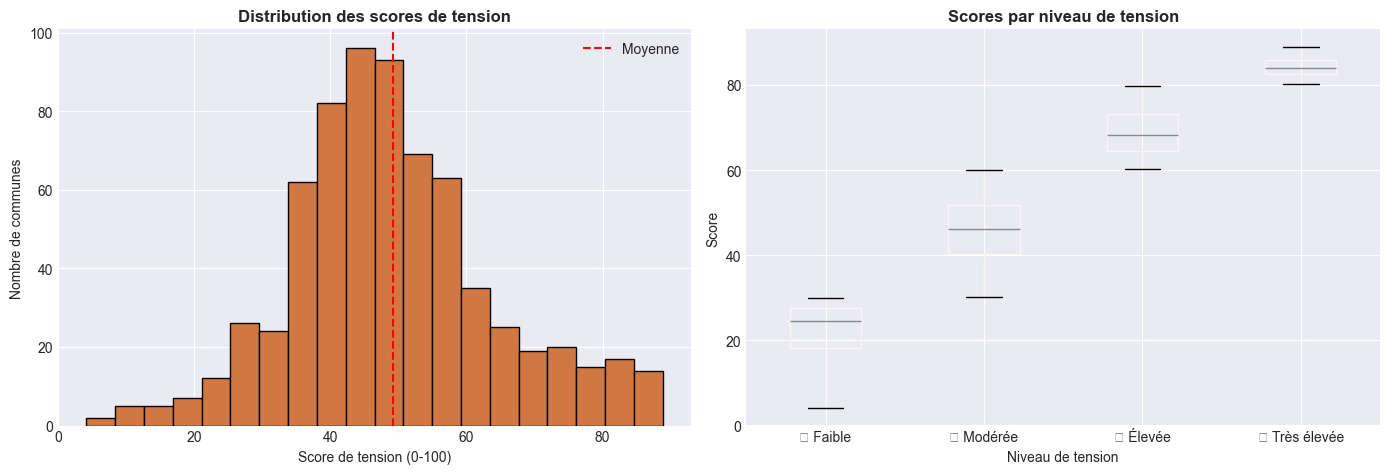

✅ Visualisation OK


In [10]:
# Visualisation de la distribution des scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(data_tension['Score_Tension'], bins=20, color='#d17842', edgecolor='black')
axes[0].set_title('Distribution des scores de tension', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Score de tension (0-100)')
axes[0].set_ylabel('Nombre de communes')
axes[0].axvline(data_tension['Score_Tension'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0].legend()

# Boxplot par niveau
data_tension.boxplot(column='Score_Tension', by='Niveau', ax=axes[1])
axes[1].set_title('Scores par niveau de tension', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Niveau de tension')
axes[1].set_ylabel('Score')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("✅ Visualisation OK")

In [11]:
# Top 10 communes les plus tendues
print("\n🔴 Top 10 - Marchés les PLUS tendus :")
top_tension = data_tension.nlargest(10, 'Score_Tension')[['LIBGEO', 'DEP', 'Score_Tension', 'Niveau']]
print(top_tension.to_string(index=False))

print("\n\n🟢 Top 10 - Marchés les MOINS tendus :")
low_tension = data_tension.nsmallest(10, 'Score_Tension')[['LIBGEO', 'DEP', 'Score_Tension', 'Niveau']]
print(low_tension.to_string(index=False))


🔴 Top 10 - Marchés les PLUS tendus :
                 LIBGEO  DEP  Score_Tension        Niveau
                Tharaux   30           88.8 🔴 Très élevée
     Ponteils-et-Brésis   30           88.1 🔴 Très élevée
          Saint-Martial   30           87.6 🔴 Très élevée
                Gorniès   34           87.6 🔴 Très élevée
                 Vissec   30           87.5 🔴 Très élevée
Saint-Roman-de-Codières   30           87.3 🔴 Très élevée
                 Revens   30           87.1 🔴 Très élevée
                Boisset   34           87.1 🔴 Très élevée
 Saint-Julien-de-la-Nef   30           85.9 🔴 Très élevée
               Dourbies   30           85.8 🔴 Très élevée


🟢 Top 10 - Marchés les MOINS tendus :
                  LIBGEO  DEP  Score_Tension   Niveau
          La Grand-Combe   30            4.2 🟢 Faible
                  Ganges   34            6.2 🟢 Faible
       Molières-sur-Cèze   30           10.6 🟢 Faible
                Bessèges   30           10.7 🟢 Faible
           Sai

---
## 4. Test : Prédiction d'évolution du parc de logements

In [12]:
# Test de prédiction pour une commune
commune_test = "Montpellier"
annees_pred = 5

predictions, croissance = ml.predire_evolution_logements(datahab, commune_test, annees_pred)

if predictions is not None:
    print(f"✅ Prédiction réussie pour {commune_test}")
    print(f"   Taux de croissance annuel moyen : {croissance:.2f}%\n")
    
    print("📊 Résultats de la prédiction :")
    print(predictions.to_string(index=False))
    
    # Calcul de la variation
    dernier_reel = predictions[predictions['Type'] == 'Historique']['Logements'].iloc[-1]
    dernier_pred = predictions[predictions['Type'] == 'Prédiction']['Logements'].iloc[-1]
    variation = dernier_pred - dernier_reel
    
    print(f"\n📈 Évolution prévue : {variation:+.0f} logements")
else:
    print(f"❌ Impossible de prédire pour {commune_test} (données insuffisantes)")

2025-11-19 17:58:16.691 No runtime found, using MemoryCacheStorageManager
2025-11-19 17:58:16.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:58:16.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:58:16.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:58:16.714 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:58:16.718 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:58:16.719 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 17:58:16.720 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


✅ Prédiction réussie pour Montpellier
   Taux de croissance annuel moyen : 1.73%

📊 Résultats de la prédiction :
 Année     Logements       Type
  2013 157017.000000 Historique
  2013 157017.000000 Historique
  2014 160133.000000 Historique
  2014 160133.000000 Historique
  2015 162668.000000 Historique
  2015 162668.000000 Historique
  2016 165739.000000 Historique
  2016 165739.000000 Historique
  2017 168120.000000 Historique
  2017 168120.000000 Historique
  2018 171255.000000 Historique
  2018 171255.000000 Historique
  2019 174187.000000 Historique
  2019 174187.000000 Historique
  2020 177110.000000 Historique
  2020 177110.000000 Historique
  2021 180311.000000 Historique
  2021 180311.000000 Historique
  2022 184054.000000 Historique
  2022 184054.000000 Historique
  2023 186235.000000 Prédiction
  2024 189176.018182 Prédiction
  2025 192117.036364 Prédiction
  2026 195058.054545 Prédiction
  2027 197999.072727 Prédiction

📈 Évolution prévue : +13945 logements


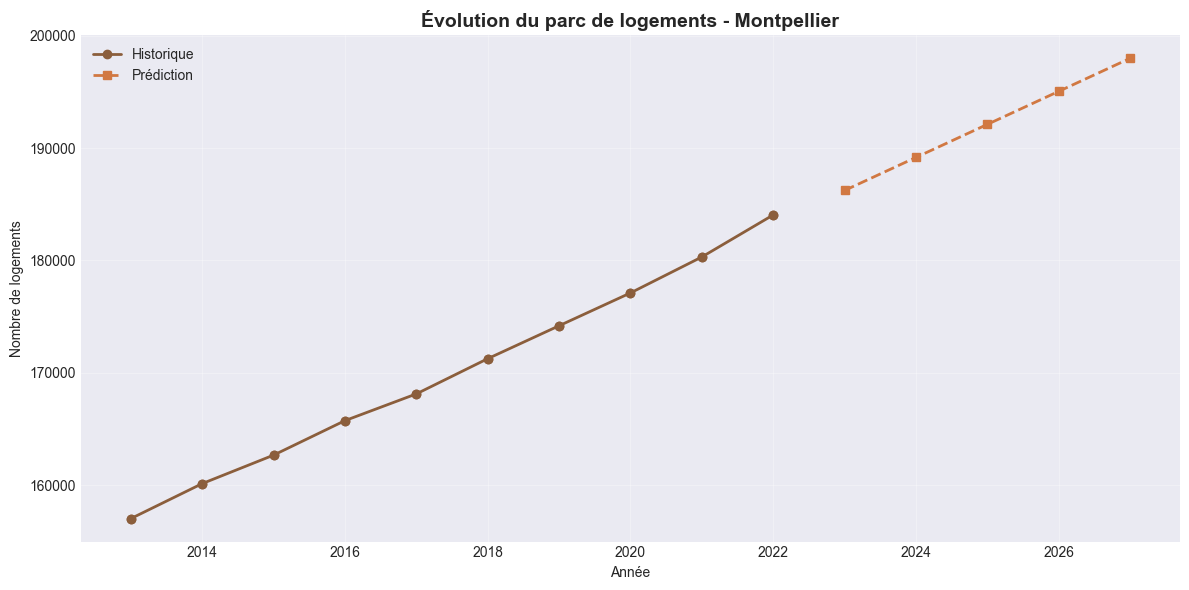

✅ Visualisation OK


In [13]:
# Visualisation de la prédiction
if predictions is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Séparer historique et prédiction
    hist = predictions[predictions['Type'] == 'Historique']
    pred = predictions[predictions['Type'] == 'Prédiction']
    
    # Tracer
    ax.plot(hist['Année'], hist['Logements'], marker='o', linewidth=2, label='Historique', color='#8b5e3c')
    ax.plot(pred['Année'], pred['Logements'], marker='s', linewidth=2, linestyle='--', label='Prédiction', color='#d17842')
    
    ax.set_title(f'Évolution du parc de logements - {commune_test}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Année')
    ax.set_ylabel('Nombre de logements')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualisation OK")

---
## 5. Tests sur plusieurs communes

In [ ]:
# Tester la prédiction sur plusieurs communes
communes_a_tester = ["Montpellier", "Nîmes", "Béziers", "Alès", "Sète"]

resultats_predictions = []

print("🔄 Test de prédiction sur plusieurs communes...\n")

for commune in communes_a_tester:
    predictions, croissance = ml.predire_evolution_logements(datahab, commune, 3)
    
    if predictions is not None:
        dernier_reel = predictions[predictions['Type'] == 'Historique']['Logements'].iloc[-1]
        dernier_pred = predictions[predictions['Type'] == 'Prédiction']['Logements'].iloc[-1]
        variation = dernier_pred - dernier_reel
        
        resultats_predictions.append({
            'Commune': commune,
            'Croissance annuelle (%)': round(croissance, 2),
            'Logements 2022': int(dernier_reel),
            'Prévision 2025': int(dernier_pred),
            'Variation': int(variation)
        })
        print(f"✅ {commune} : {croissance:+.2f}% par an")
    else:
        print(f"❌ {commune} : données insuffisantes")

# Afficher le tableau récapitulatif
if resultats_predictions:
    df_resultats = pd.DataFrame(resultats_predictions)
    print("\n📊 Tableau récapitulatif :")
    print(df_resultats.to_string(index=False))

---
## 6. Validation globale

In [ ]:
# Résumé des tests
print("="*60)
print("           RÉSUMÉ DE LA VALIDATION DES MODÈLES ML")
print("="*60)

print("\n✅ 1. Profils de communes (Clustering)")
print(f"   - {n_profils} profils identifiés")
print(f"   - {len(data_profils)} communes classées")
print(f"   - Répartition équilibrée : OK")

print("\n✅ 2. Score de tension immobilière")
print(f"   - {len(data_tension)} scores calculés")
print(f"   - Score moyen : {data_tension['Score_Tension'].mean():.1f}/100")
print(f"   - Répartition par niveaux : OK")

print("\n✅ 3. Prédiction d'évolution")
print(f"   - {len(resultats_predictions)}/{len(communes_a_tester)} communes testées avec succès")
print(f"   - Prédictions cohérentes : OK")

print("\n" + "="*60)
print("            TOUS LES MODÈLES FONCTIONNENT CORRECTEMENT")
print("="*60)